### <center>Data Munging with Apache Spark: Using Spark-CSV and exploring data, _with R_.</center>
<center>@geraudster</center>

![TDS Logo](http://photos1.meetupstatic.com/photos/event/8/a/5/2/global_434255410.jpeg)


Manual loading and saving CSV files using RDDs is a cumbersome and error-prone process. Fortunately, Spark ecosystem is growing fast and there is a library for parsing and querying CSV data with Apache Spark, for Spark SQL and DataFrames. See https://github.com/databricks/spark-csv

Note: In order to use this library you have to start pyspark with `--packages com.databricks:spark-csv_2.11:1.3.0` option.

First, we will initialize the Spark context (sc) by setting some environment variables and loading the _SparkR_ package:

In [1]:
# Set this to where Spark is installed
Sys.setenv(SPARK_HOME="/opt/spark/spark-1.6.1-bin-hadoop2.6")
Sys.setenv('SPARKR_SUBMIT_ARGS'='"--packages" "com.databricks:spark-csv_2.11:1.3.0" "sparkr-shell"')

# This line loads SparkR from the installed directory
.libPaths(c(file.path(Sys.getenv("SPARK_HOME"), "R", "lib"), .libPaths()))

# Load the SparkR library
library(SparkR)
sc <- sparkR.init(master="local[*]")


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var

The following objects are masked from ‘package:base’:

    colnames, colnames<-, endsWith, intersect, rank, rbind, sample,
    startsWith, subset, summary, table, transform



Launching java with spark-submit command /opt/spark/spark-1.6.1-bin-hadoop2.6/bin/spark-submit   "--packages" "com.databricks:spark-csv_2.11:1.3.0" "sparkr-shell" /tmp/RtmpLCOFlm/backend_port1da3a69360f 


### Loading CSV with Spark-CSV library

In [2]:
sqlContext <- sparkRSQL.init(sc)
bikes <- read.df(sqlContext,
                 path = 'data/bike_sharing/usage_hourly.csv',
                 source = 'com.databricks.spark.csv',
                 header = 'true',
                 inferschema = 'true')

Print inferred shema:

In [3]:
printSchema(bikes)

root
 |-- datetime: timestamp (nullable = true)
 |-- season: string (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- count: integer (nullable = true)


We can also use `str` function to see R types:

In [4]:
str(bikes)

'DataFrame': 7 variables:
 $ datetime  : POSIXct 2011-01-01 00:00:00 2011-01-01 01:00:00 2011-01-01 02:00:00 2011-01-01 03:00:00 2011-01-01 04:00:
 $ season    : chr "springer" "springer" "springer" "springer" "springer" "springer"
 $ holiday   : int 0 0 0 0 0 0
 $ workingday: int 0 0 0 0 0 0
 $ casual    : int 3 8 5 3 0 0
 $ registered: int 13 32 27 10 1 1
 $ count     : int 16 40 32 13 1 1


Show 5 first rows:

In [5]:
head(bikes, 5)

,datetime,season,holiday,workingday,casual,registered,count
1,2011-01-01 00:00:00,springer,0,0,3,13,16
2,2011-01-01 01:00:00,springer,0,0,8,32,40
3,2011-01-01 02:00:00,springer,0,0,5,27,32
4,2011-01-01 03:00:00,springer,0,0,3,10,13
5,2011-01-01 04:00:00,springer,0,0,0,1,1


Convert columns `holiday` and `workingday` from numeric to boolean

In [6]:
bikes$holiday <- bikes$holiday == 1
bikes$workingday <- bikes$workingday == 1

In [7]:
head(bikes)

,datetime,season,holiday,workingday,casual,registered,count
1,2011-01-01 00:00:00,springer,FALSE,FALSE,3,13,16
2,2011-01-01 01:00:00,springer,FALSE,FALSE,8,32,40
3,2011-01-01 02:00:00,springer,FALSE,FALSE,5,27,32
4,2011-01-01 03:00:00,springer,FALSE,FALSE,3,10,13
5,2011-01-01 04:00:00,springer,FALSE,FALSE,0,1,1
6,2011-01-01 05:00:00,springer,FALSE,FALSE,0,1,1


#### Now, load weather data

In [8]:
weather <- read.df(sqlContext,
                   path = 'data/bike_sharing/weather.csv',
                   source = 'com.databricks.spark.csv',
                   header = 'true',
                   inferschema = 'true')

In [9]:
printSchema(weather)

root
 |-- date: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weather: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- windspeed: double (nullable = true)


In [10]:
head(weather)

,date,hour,weather,temp,atemp,humidity,windspeed
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,81,0
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0
6,2011-01-01,5,"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",9.84,12.88,75,6.003


#### Computes very basic statistics for numeric columns.

In [11]:
collect(summary(weather))

,summary,date,hour,weather,temp,atemp,humidity,windspeed
1,count,17379,17379,17379,17379,17379,17379,17379
2,mean,NA,11.546751826917545,NA,20.376473905287963,23.78875510673787,62.722883940387824,12.73647350250328
3,stddev,NA,6.914405095264506,NA,7.894800971238591,8.592510781767942,19.29298340629151,8.19677122859822
4,min,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.82,0.0,0.0,0.0
5,max,2012-12-31,23,"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",41.0,50.0,100.0,56.997


### Join bikes usage and weather

In [12]:
# Format date time
weather$w_datetime <- to_utc_timestamp(format_string('%s %02d:00', weather$date, weather$hour), 'UTC')

bikes_weather <- select(join(bikes, weather, bikes$datetime == weather$w_datetime), # inner join
                        c('datetime', 'season', 'holiday', 'workingday',  'weather', 
                         'temp', 'atemp','humidity','windspeed','casual', 'registered', 'count'))

head(orderBy(bikes_weather, 'datetime'))

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1,2011-01-01 00:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,81,0,3,13,16
2,2011-01-01 01:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0,8,32,40
3,2011-01-01 02:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0,5,27,32
4,2011-01-01 03:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0,3,10,13
5,2011-01-01 04:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0,0,1,1
6,2011-01-01 05:00:00,springer,FALSE,FALSE,"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",9.84,12.88,75,6.003,0,1,1


Same, but in a more functional way:

In [13]:
library(magrittr)

bikes_weather <- bikes %>%
                 join(weather, bikes$datetime == weather$w_datetime) %>% # inner join
                 select(c('datetime', 'season', 'holiday', 'workingday',  'weather', 
                         'temp', 'atemp','humidity','windspeed','casual', 'registered', 'count'))
bikes_weather %>%
    orderBy('datetime') %>%
    head

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1,2011-01-01 00:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,81,0,3,13,16
2,2011-01-01 01:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0,8,32,40
3,2011-01-01 02:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0,5,27,32
4,2011-01-01 03:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0,3,10,13
5,2011-01-01 04:00:00,springer,FALSE,FALSE,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0,0,1,1
6,2011-01-01 05:00:00,springer,FALSE,FALSE,"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",9.84,12.88,75,6.003,0,1,1


## Introducing Spark SQL

Spark SQL is the Spark's interface for working with structured and semistructured data. Spark SQL makes it both easier and more efficient to load and query. Under the hood, Spark SQL is based on an extension of the RDD model caled DataFrame, ohh yes, you already know how to that :-) 

When programming against Spark SQL we have two entry points depending on whether we need Hive support. In this notebook we simply use `SQLContext`, which provides a basic subset of Spark SQL support that does not depend on Hive.

For more detailed documentation: http://spark.apache.org/docs/latest/sql-programming-guide.html

In [14]:
registerTempTable(bikes_weather, 'bikes_weather')

#### Count all records

In [15]:
collect(sql(sqlContext, 'select count(*) from bikes_weather'))

,_c0
1,17379


####  Select the 10 first records whose temperature is greather than 10 and less than 45. Display date with hour, season and number of rentals. 

In [16]:
collect(sql(sqlContext, '
SELECT datetime, season, count
FROM bikes_weather 
WHERE temp BETWEEN 10 AND 45
LIMIT 10'))

,datetime,season,count
1,2011-01-15 19:00:00,springer,74
2,2011-02-13 11:00:00,springer,112
3,2011-03-04 22:00:00,springer,44
4,2011-03-20 10:00:00,springer,136
5,2011-03-22 01:00:00,summer,19
6,2011-03-24 01:00:00,summer,3
7,2011-04-11 08:00:00,summer,314
8,2011-05-30 15:00:00,summer,311
9,2011-06-19 22:00:00,summer,152
10,2011-07-03 20:00:00,fall,176


### SQL, old-fashioned? 

#### Not yet, let's practise: write a SQL statement which computes the average rentals per hour and day of week on the entire dataset.

May you find this link useful: https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF#LanguageManualUDF-DateFunctions

In [17]:
sql_rentals_hour_weekday <- sql(sqlContext, "
SELECT HOUR(datetime) AS hour, date_format(datetime, 'EEEE') AS weekday, AVG(count) as avg_count
FROM bikes_weather
GROUP BY HOUR(datetime), date_format(datetime, 'EEEE')
")

head(sql_rentals_hour_weekday)

,hour,weekday,avg_count
1,18,Monday,481.346153846154
2,7,Saturday,45.9619047619048
3,10,Thursday,132.563106796117
4,1,Sunday,77.4326923076923
5,14,Friday,229.365384615385
6,2,Wednesday,7.81372549019608


#### Now the same with Data Frame API

In [18]:
df_rentals_hour_weekday <- bikes_weather %>%
                           withColumn('hour', hour(.$datetime)) %>%
                           withColumn('weekday', date_format(.$datetime, 'EEEE')) %>%
                           groupBy('hour', 'weekday') %>%
                           avg('count')
head(df_rentals_hour_weekday)

,hour,weekday,avg(count)
1,18,Monday,481.346153846154
2,7,Saturday,45.9619047619048
3,10,Thursday,132.563106796117
4,1,Sunday,77.4326923076923
5,14,Friday,229.365384615385
6,2,Wednesday,7.81372549019608


### Doing some Exploratory Data Analysis

R package _rpivotTable_ (which uses pivottable.js) is not working yet with Jupyter, we will use ggplot2 to draw a few graphs.

In [19]:
library(ggplot2)
r_df_rentals_hour_weekday <- as.data.frame(df_rentals_hour_weekday) # convert to R data.frame

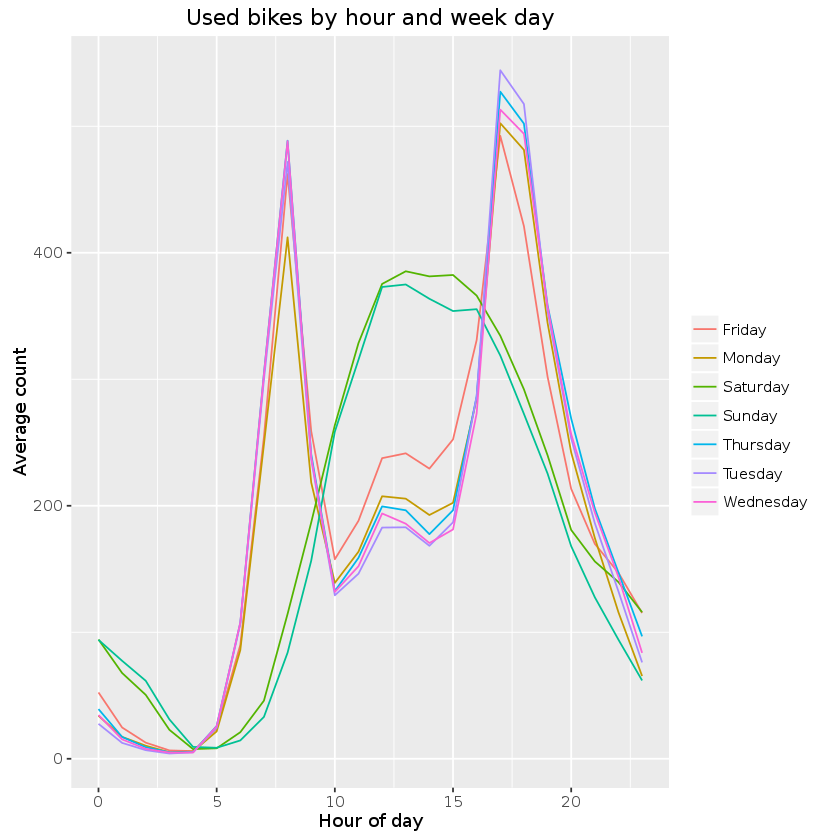

In [20]:
ggplot(r_df_rentals_hour_weekday, aes(hour, `avg(count)`, group = weekday,
                                      colour = weekday)) +
      geom_line() +
      xlab('Hour of day') +
      ylab('Average count') +
      ggtitle('Used bikes by hour and week day') +
      theme(legend.title=element_blank())